In [1]:
from pathlib import Path
from typing import List
from trap.frame_emitter import Track
from trap.frame_emitter import Camera
from trap.tracker import TrackReader
import numpy as np


path = Path("EXPERIMENTS/raw/hof3/")
calibration_path = Path("../DATASETS/hof3/calibration.json")
homography_path = Path("../DATASETS/hof3/homography.json")
camera = Camera.from_paths(calibration_path, homography_path, 12)


/home/ruben/suspicion/trap/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
reader = TrackReader(path, camera.fps, exclude_whitelisted = False, include_blacklisted=False)

In [3]:
from trap.tracker import FinalDisplacementFilter


tracks: List[Track] = [t for t in reader]
filter = FinalDisplacementFilter(2)
tracks = filter.apply(tracks, camera)

In [4]:
print(len(tracks))
track =tracks[0]
track

2379


Track(track_id='7', history=[Detection(track_id='7', l=1320.8199462890625, t=251.9683380126953, w=111.053955078125, h=234.67745971679688, conf=1, state=<DetectionState.Confirmed: 2>, frame_nr=3264, det_class=1), Detection(track_id='7', l=1339.9742431640625, t=238.920166015625, w=105.037109375, h=222.37574768066406, conf=1, state=<DetectionState.Confirmed: 2>, frame_nr=3265, det_class=1), Detection(track_id='7', l=1352.3323974609375, t=229.05804443359375, w=104.625732421875, h=221.97633361816406, conf=1, state=<DetectionState.Confirmed: 2>, frame_nr=3266, det_class=1), Detection(track_id='7', l=1359.267822265625, t=220.7544708251953, w=106.5965576171875, h=226.98056030273438, conf=1, state=<DetectionState.Confirmed: 2>, frame_nr=3267, det_class=1), Detection(track_id='7', l=1362.710693359375, t=213.61810302734375, w=109.2371826171875, h=233.524169921875, conf=1, state=<DetectionState.Confirmed: 2>, frame_nr=3268, det_class=1), Detection(track_id='7', l=1364.126708984375, t=203.141204833

In [5]:

from trap.tracker import Smoother


smoother = Smoother(12, convolution=True)

In [6]:
import cv2
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
import tqdm


In [7]:
track.get_binned(.5, camera, True)

[{'x': 12.0, 'y': 7.0},
 {'x': 12.5, 'y': 6.5},
 {'x': 13.0, 'y': 6.0},
 {'x': 13.0, 'y': 5.5},
 {'x': 13.0, 'y': 5.0},
 {'x': 13.0, 'y': 4.5},
 {'x': 13.0, 'y': 4.0},
 {'x': 13.5, 'y': 3.5},
 {'x': 13.5, 'y': 3.0}]

100%|██████████| 2379/2379 [00:20<00:00, 113.44it/s]


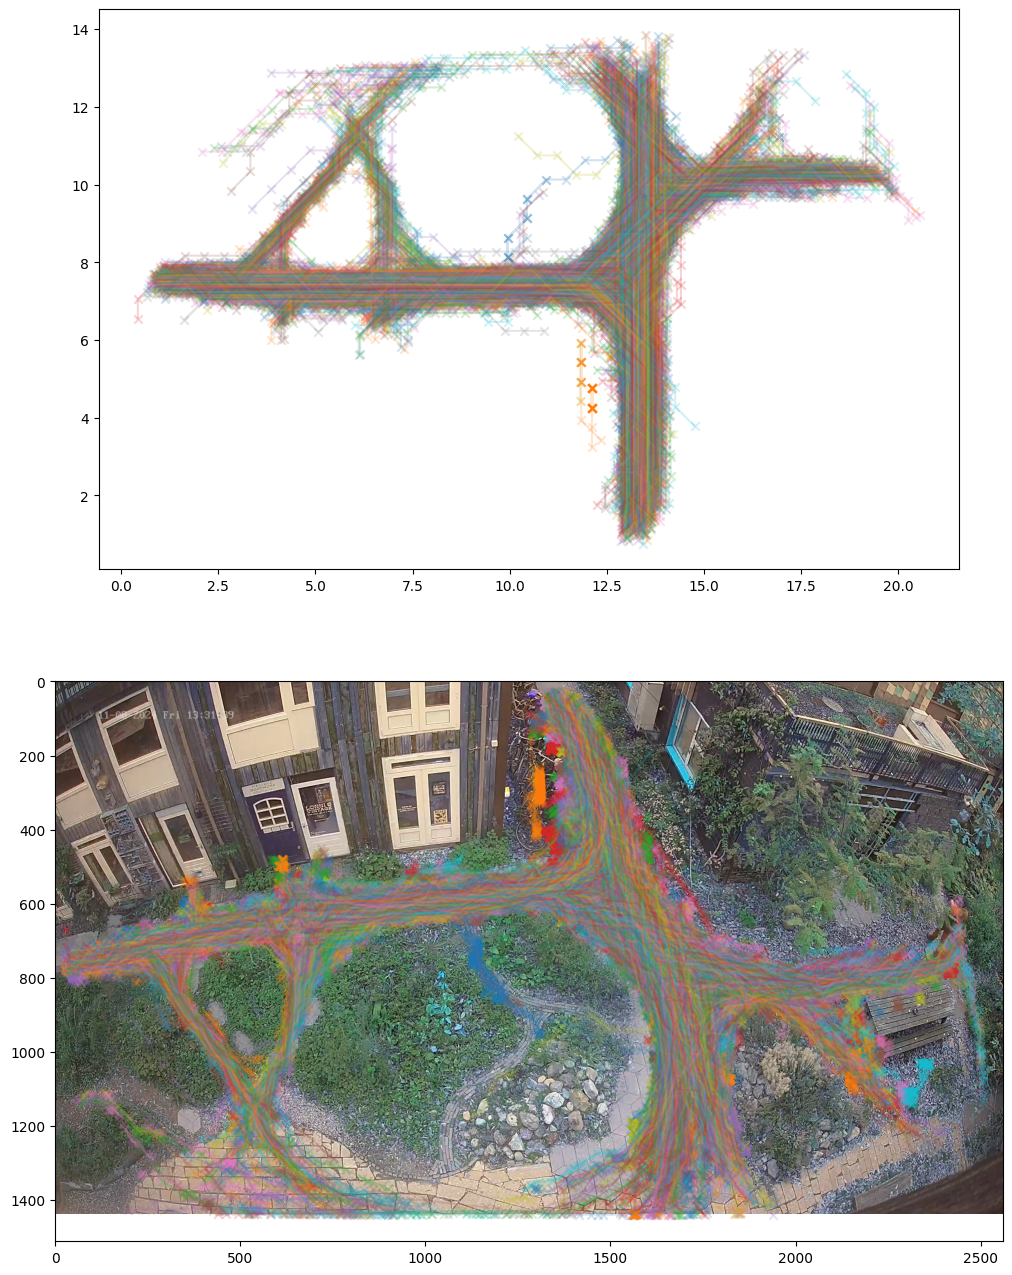

In [ ]:
fig = plt.figure(figsize=(20,16))
ax1, ax2 = fig.subplots(2)

im = cv2.imread("../DATASETS/hof3/output.png")
ax2.imshow(im)
ax1.set_aspect(1)
ax2.set_aspect(1)

for track in (bar:= tqdm.tqdm(tracks)):
    t = track.get_with_interpolated_history()
    t = smoother.smooth_track(t)
    binned_points = t.get_binned(.5, camera, bin_start=True)
    points = np.array([[p['x'],p['y']] for p in binned_points])
    x, y = points[:,0], points[:,1]
    ax1.plot(x, y, alpha=.2)
    ax1.scatter(x, y, marker='x', alpha=.2)

    
    # points = t.get_projected_history(None, camera)
    # x, y = points[:,0], points[:,1]
    # ax1.plot(x, y, alpha=.2)
    # ax1.scatter(x, y, marker='x', alpha=.2)

    # print (binned_points, points)



    l = [d.get_foot_coords()[0] for d in track.history]
    t = [d.get_foot_coords()[1] for d in track.history]
    ax2.plot(l, t, alpha=.2)
    ax2.scatter(l, t, marker='x', alpha=.2)

    # if bar.n > 25:
    #     break
    # if bar.n > 100:
    #     break

NameError: name 'tracks' is not defined

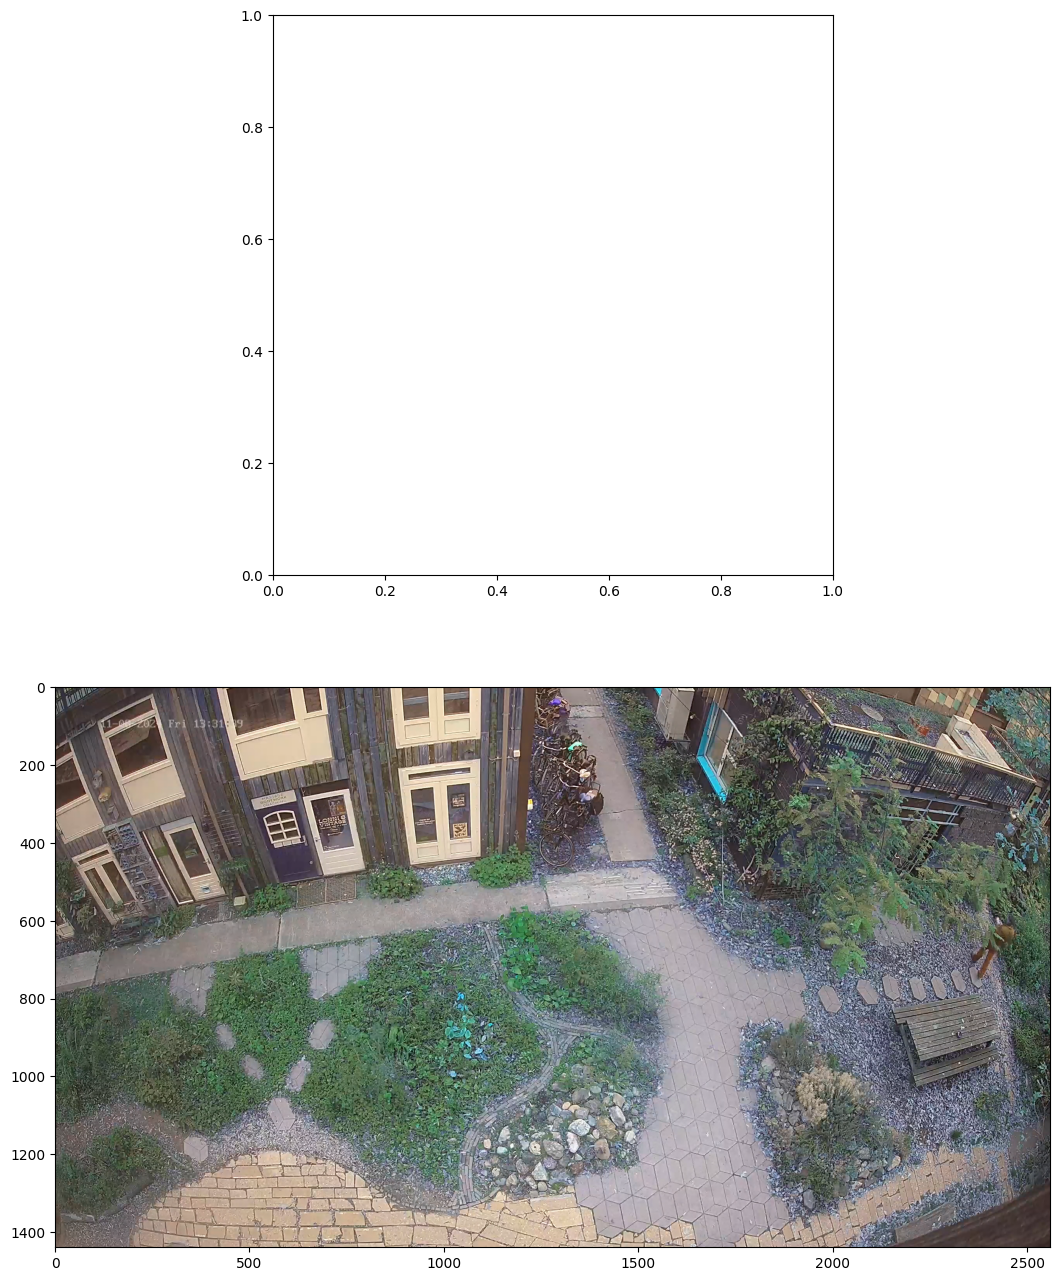

In [2]:

fig = plt.figure(figsize=(20,16))
ax1, ax2 = fig.subplots(2)

im = cv2.imread("../DATASETS/hof3/output.png")
ax2.imshow(im)
ax1.set_aspect(1)
ax2.set_aspect(1)



for track in (bar:= tqdm.tqdm(tracks)):
    t = track.get_with_interpolated_history()
    t = smoother.smooth_track(t)
    points = t.get_projected_history(None, camera)
    x, y = points[:,0], points[:,1]
    ax1.plot(x, y, alpha=.2)
    ax1.scatter(x, y, marker='x', alpha=.2)
    l = [d.get_foot_coords()[0] for d in track.history]
    t = [d.get_foot_coords()[1] for d in track.history]
    ax2.plot(l, t, alpha=.2)
    ax2.scatter(l, t, marker='x', alpha=.2)
    # if bar.n > 100:
    #     break

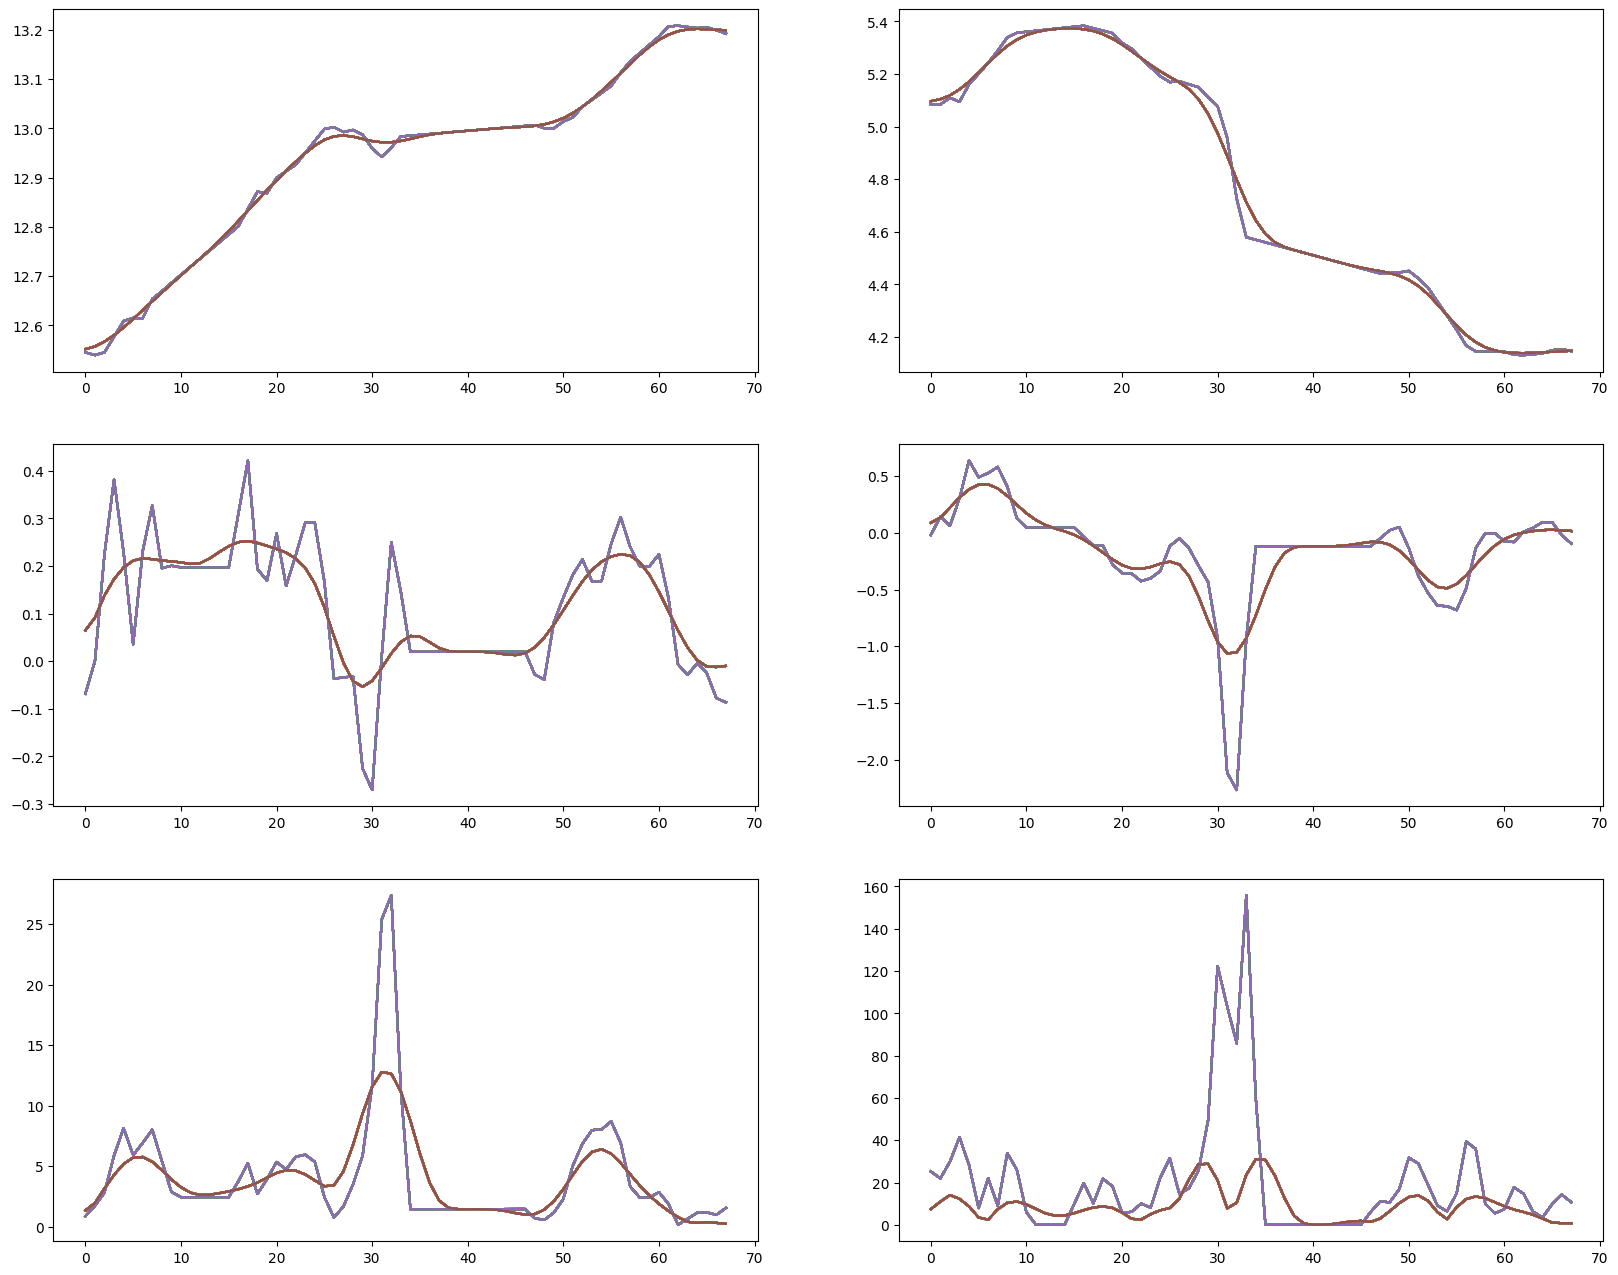

In [10]:
import numpy as np
from trajectron.environment import Environment

from trap.tracker import Smoother
env = Environment(node_type_list=['PEDESTRIAN'], standardization=None)
n = 9
# n = 20
# n = 21
# print([d.frame_nr for d in tracks[n].history])
track = tracks[n].get_with_interpolated_history()
node_s = smoother.smooth_track(track).to_trajectron_node(camera, env)
node_o = track.to_trajectron_node(camera, env)
# print(node.data[:, {'velocity': ['x', 'y']}] * 12)

fig = plt.figure(figsize=(20,16))
(ax1, ax2), (ax3, ax4), (ax5, ax6) = fig.subplots(3,2)

for i in range(len(track.history)):
    ax1.plot(node_o.data[:, {'position': ['x']}])
    ax1.plot(node_s.data[:, {'position': ['x']}])
    ax2.plot(node_o.data[:, {'position': ['y']}])
    ax2.plot(node_s.data[:, {'position': ['y']}])
    ax3.plot(node_o.data[:, {'velocity': ['x']}])
    ax3.plot(node_s.data[:, {'velocity': ['x']}])
    ax4.plot(node_o.data[:, {'velocity': ['y']}])
    ax4.plot(node_s.data[:, {'velocity': ['y']}])
    ax5.plot(np.linalg.norm(node_o.data[:, {'velocity': ['x', 'y']}], axis=1) * 12)
    ax5.plot(np.linalg.norm(node_s.data[:, {'velocity': ['x', 'y']}], axis=1) * 12)
    
    ax6.plot(np.linalg.norm(node_o.data[:, {'acceleration': ['x', 'y']}], axis=1) * 12)
    ax6.plot(np.linalg.norm(node_s.data[:, {'acceleration': ['x', 'y']}], axis=1) * 12)
    # np.linalg.norm(node.data[:, {'acceleration': ['x', 'y']}], axis=1) * 12
# node.data[:, {'acceleration': ['x', 'y']}]

  1%|          | 20/2379 [00:00<00:11, 196.76it/s]

[{'x': 12.419917, 'y': 6.629327}, {'x': 11.919917106628418, 'y': 6.129326820373535}, {'x': 11.419917106628418, 'y': 5.629326820373535}, {'x': 11.419917106628418, 'y': 5.129326820373535}, {'x': 11.919917106628418, 'y': 4.629326820373535}, {'x': 12.419917106628418, 'y': 4.129326820373535}, {'x': 12.419917106628418, 'y': 3.629326820373535}, {'x': 12.919917106628418, 'y': 3.129326820373535}] [[      12.42      6.6293]
 [     12.445      6.6081]
 [      12.49      6.5677]
 [     12.549      6.5107]
 [     12.612      6.4391]
 [     12.673       6.354]
 [     12.729      6.2547]
 [     12.782      6.1409]
 [     12.834      6.0165]
 [     12.882       5.888]
 [     12.927      5.7595]
 [     12.967      5.6316]
 [     13.004      5.5034]
 [     13.039      5.3739]
 [     13.071      5.2438]
 [     13.101      5.1151]
 [     13.128      4.9896]
 [     13.151      4.8678]
 [     13.171      4.7487]
 [     13.187        4.63]
 [     13.201      4.5105]
 [     13.214      4.3919]
 [     13.225  

  2%|▏         | 40/2379 [00:00<00:13, 175.85it/s]


[{'x': 13.174498, 'y': 2.6993177}, {'x': 13.674497604370117, 'y': 3.199317693710327}] [[     13.174      2.6993]
 [     13.181      2.7241]
 [     13.194      2.7686]
 [     13.212      2.8273]
 [      13.23      2.8973]
 [     13.247       2.978]
 [      13.26      3.0702]
 [     13.269      3.1727]
 [     13.274      3.2809]
 [     13.277      3.3885]
 [     13.279      3.4911]
 [      13.28      3.5882]
 [     13.281      3.6817]
 [     13.282      3.7771]
 [     13.284      3.8793]
 [     13.288      3.9887]
 [     13.295      4.1037]
 [     13.305      4.2231]
 [     13.317      4.3461]
 [     13.328      4.4723]
 [     13.339       4.601]
 [     13.348      4.7298]
 [     13.356      4.8535]
 [     13.364      4.9673]
 [     13.372      5.0714]
 [     13.379      5.1691]
 [     13.385       5.265]
 [      13.39      5.3638]
 [     13.396      5.4672]
 [     13.404      5.5741]
 [     13.416      5.6829]
 [     13.432      5.7943]
 [     13.448      5.9095]
 [     13.464      6.02

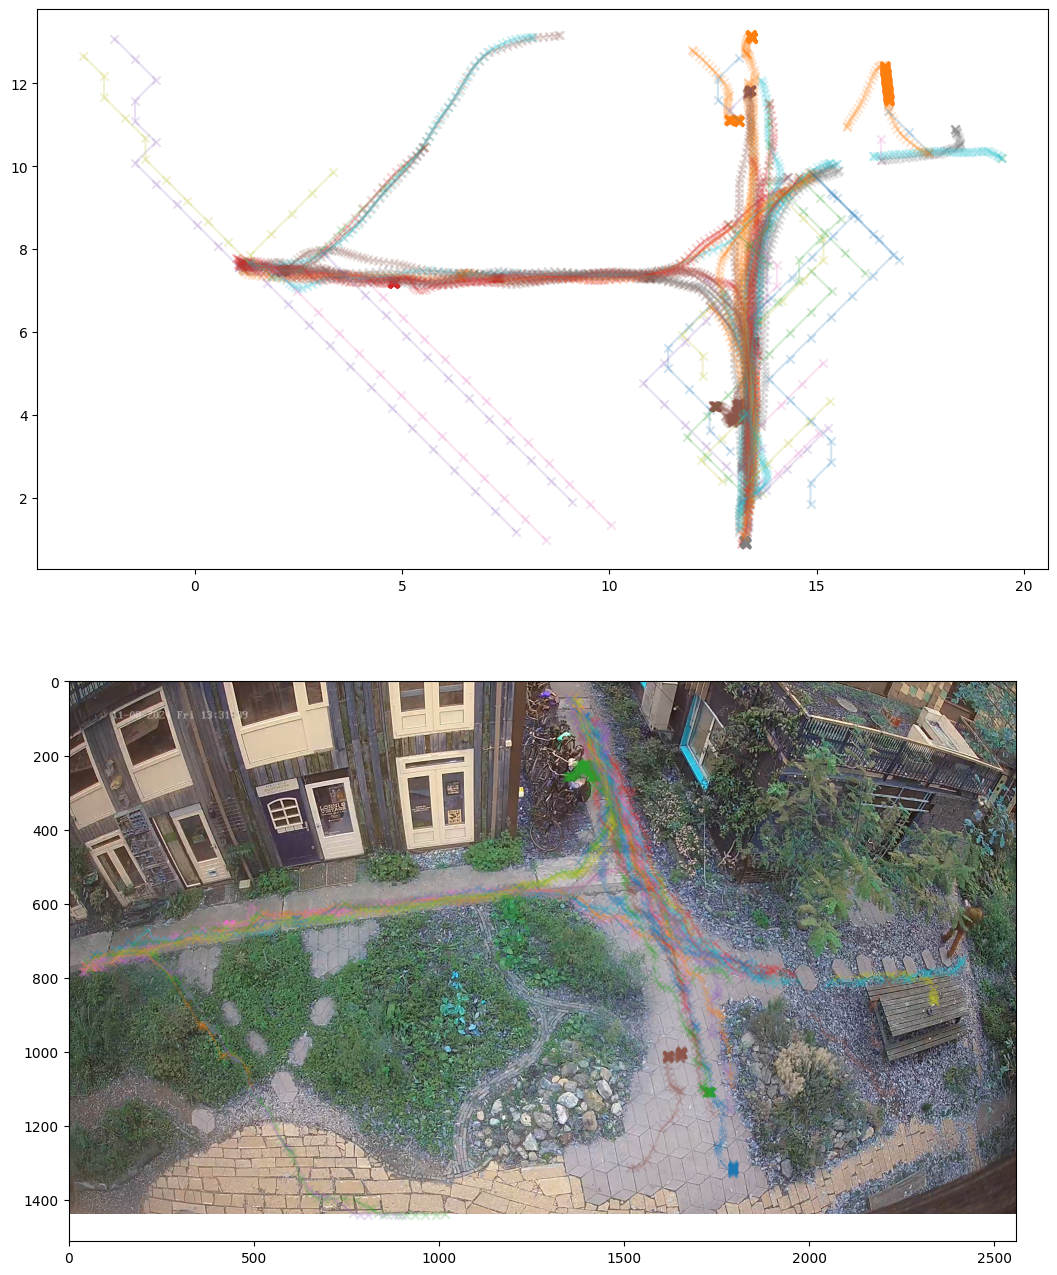